In [1]:
import cv2,os
import time
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from skimage import io, transform
from skimage.io import imread, imshow

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToPILImage
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cpu)


# debug

In [3]:
# path = data_dir
# folders = os.listdir(path)
# idx = 1

# image_folder = os.path.join(path,folders[idx],'images/')
# mask_folder = os.path.join(path,folders[idx],'masks/')
# image_path = os.path.join(image_folder,os.listdir(image_folder)[0])

# masks = np.zeros((len(os.listdir(mask_folder)), 256, 256), dtype=np.uint8)
# for i in range(len(os.listdir(mask_folder))):
#     mask = os.listdir(mask_folder)[i]
#     mask = io.imread(os.path.join(mask_folder,mask))
#     mask = cv2.resize(mask, (256, 256))
#     mask = np.array(mask) > 0
#     masks[i, :, :] = mask


    
    
# # hist = cv2.calcHist([mk],[0],None,[256],[0,256])

# print(masks.shape)
# # print(hist)
# plt.imshow(masks[0])

# data for train

In [4]:
batch_size=1
image_size=512

data_dir = "../../Datasets/data-science-bowl-2018/stage1_train/"

In [5]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = transforms.functional.to_tensor(image)
        return image, target
    
def get_transform():
    transforms = [ToTensor()]
    return Compose(transforms)

len(datas):  14
torch.Size([39, 4])
torch.Size([39])
torch.Size([39, 512, 512])
torch.Size([39])
torch.Size([39])
torch.uint8


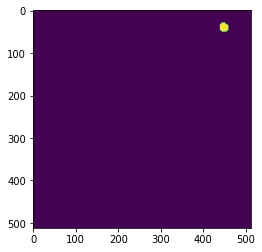

In [14]:
class CustomDataset(Dataset):
    def __init__(self,path,transforms):
        self.path = path
        self.folders = os.listdir(path)
        self.transforms = transforms

    def __getitem__(self,idx):
        image_folder = os.path.join(self.path,self.folders[idx],'images/')
        mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
        image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
    
        img = io.imread(image_path)[:,:,:3]
        img = transform.resize(img, (image_size,image_size))
        masks, boxes = self.get_mask_boxes(mask_folder, image_size)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        masks = torch.tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }
        img, target = self.transforms(img, target)
        return (img,target) 

    
    
    def get_mask_boxes(self, mask_folder, img_size):
        boxes = []
        masks = np.zeros((len(os.listdir(mask_folder)), img_size, img_size), dtype=np.uint8)
        
        for i in range(len(os.listdir(mask_folder))):
            mask_ = os.listdir(mask_folder)[i]
            mask_ = io.imread(os.path.join(mask_folder,mask_))
            mask_ = cv2.resize(mask_, (img_size, img_size))
            mask_ = np.array(mask_) > 0
            masks[i, :, :] = mask_
            
            pos = np.where(mask_)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmax>xmin and ymax>ymin:
                boxes.append([xmin, ymin, xmax, ymax])

        return masks, boxes
        
    def __len__(self):
        return len(self.folders)
    
datas = CustomDataset(data_dir,get_transform())
print("len(datas): ",len(datas))
print(datas[0][1]["boxes"].shape)
print(datas[0][1]["labels"].shape)
print(datas[0][1]["masks"].shape)
print(datas[0][1]["area"].shape)
print(datas[0][1]["iscrowd"].shape)
plt.imshow(datas[0][1]["masks"][0])
print(datas[0][1]["masks"].dtype)

image.shape:  torch.Size([3, 512, 512])
mask.shape:  torch.Size([39, 512, 512])
boxes.shape:  torch.Size([39, 4])


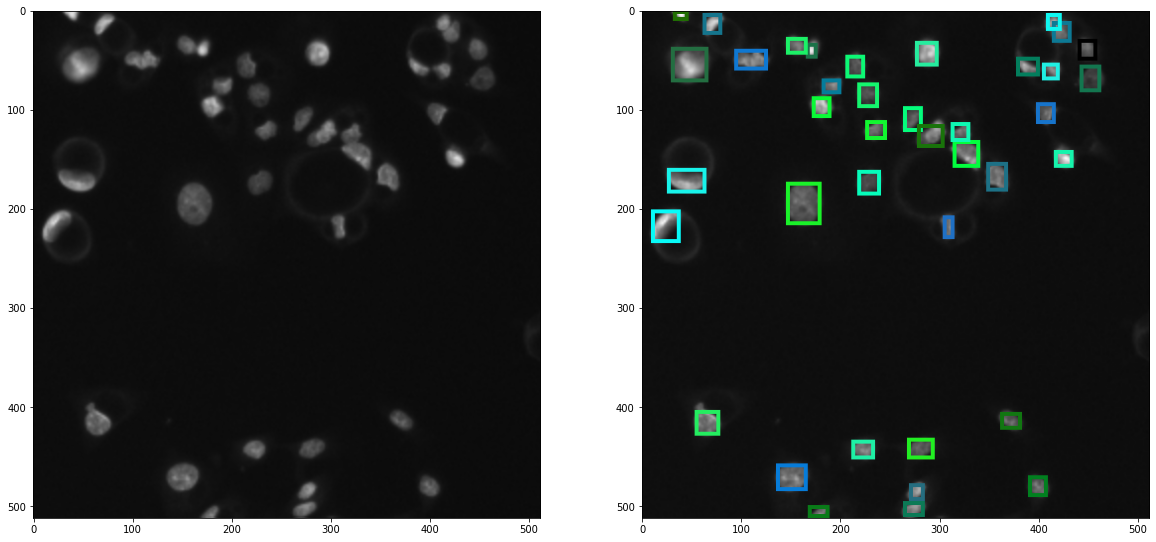

In [15]:
image, target = datas[0]
print("image.shape: ",image.shape)
# print(torch.amax(image).item(),torch.amin(image).item())
print("mask.shape: ",target["masks"].shape)
# print(torch.amax(mask).item(),torch.amin(mask).item())
print("boxes.shape: ",target["boxes"].shape)
with_boxes = draw_bounding_boxes((image*(255/torch.amax(image))).to(torch.uint8), target["boxes"], width=4)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(with_boxes.permute(1,2,0))

In [16]:
train_len = int(0.9*len(datas))
val_len = len(datas)-train_len
train_data, val_data = torch.utils.data.random_split(datas, [train_len, val_len])

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True,pin_memory=True,
                      num_workers=0, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True,pin_memory=True,
                      num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

print(f"train_data: {len(train_data)}, val_data: {len(val_data)}")
print(f"train_loader: {len(train_loader)}, val_loader: {len(val_loader)}")

val_imgs, val_targets = iter(val_loader).next()
val_imgs, val_masks = val_imgs[0], val_targets[0]["masks"]
print(f"val_imgs: {val_imgs.shape}, val_masks: {val_masks.shape}")

train_data: 12, val_data: 2
train_loader: 12, val_loader: 2
val_imgs: torch.Size([3, 512, 512]), val_masks: torch.Size([52, 512, 512])


# model for train

In [9]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [10]:
def build_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 128
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes+1) 
    return model

model = build_model(1)
model.double()
model.to(device)

for param in model.parameters():
    param.requires_grad = True
    
model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [11]:
epochs = 10
learning_rate = 3e-4
momentum = 0.9
weight_decay = 0.0005

USE_SCHEDULER = False
PCT_IMAGES_VALIDATION = 0.075

In [17]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
# optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

n_batches, n_batches_val = len(train_loader), len(val_loader)

validation_mask_losses = []

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch} of {epochs}")

    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    loss_classifier_accum = 0.0
    for batch_idx, (images, targets) in enumerate(train_loader, 1):
    
        # Predict
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask
        loss_classifier_accum += loss_dict['loss_classifier'].item()
        
        if batch_idx % 500 == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}.")
                        
    if USE_SCHEDULER:
        lr_scheduler.step()

    # Train losses
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_loss_classifier = loss_classifier_accum / n_batches

    # Validation
    val_loss_accum = 0
    val_loss_mask_accum = 0
    val_loss_classifier_accum = 0
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader, 1):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
            val_loss_mask_accum += val_loss_dict['loss_mask'].item()
            val_loss_classifier_accum += val_loss_dict['loss_classifier'].item()

    # Validation losses
    val_loss = val_loss_accum / n_batches_val
    val_loss_mask = val_loss_mask_accum / n_batches_val
    val_loss_classifier = val_loss_classifier_accum / n_batches_val
    elapsed = time.time() - time_start

    validation_mask_losses.append(val_loss_mask)
    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
    prefix = f"[Epoch {epoch:2d} / {epochs:2d}]"
    print(prefix)
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}, classifier loss {train_loss_classifier:7.3f}")
    print(f"{prefix} Val mask-only loss  : {val_loss_mask:7.3f}, classifier loss {val_loss_classifier:7.3f}")
    print(prefix)
    print(f"{prefix} Train loss: {train_loss:7.3f}. Val loss: {val_loss:7.3f} [{elapsed:.0f} secs]")
    print(prefix)

Starting epoch 1 of 10
[Epoch  1 / 10]
[Epoch  1 / 10] Train mask-only loss:   1.363, classifier loss   0.556
[Epoch  1 / 10] Val mask-only loss  :   0.485, classifier loss   0.512
[Epoch  1 / 10]
[Epoch  1 / 10] Train loss:   4.069. Val loss:   2.158 [626 secs]
[Epoch  1 / 10]
Starting epoch 2 of 10
[Epoch  2 / 10]
[Epoch  2 / 10] Train mask-only loss:   0.460, classifier loss   0.436
[Epoch  2 / 10] Val mask-only loss  :   0.383, classifier loss   0.394
[Epoch  2 / 10]
[Epoch  2 / 10] Train loss:   1.959. Val loss:   1.844 [629 secs]
[Epoch  2 / 10]
Starting epoch 3 of 10
[Epoch  3 / 10]
[Epoch  3 / 10] Train mask-only loss:   0.297, classifier loss   0.321
[Epoch  3 / 10] Val mask-only loss  :   0.311, classifier loss   0.329
[Epoch  3 / 10]
[Epoch  3 / 10] Train loss:   1.513. Val loss:   1.543 [630 secs]
[Epoch  3 / 10]
Starting epoch 4 of 10
[Epoch  4 / 10]
[Epoch  4 / 10] Train mask-only loss:   0.235, classifier loss   0.249
[Epoch  4 / 10] Val mask-only loss  :   0.288, classi

# eval of model

In [20]:
model_chk = f"pytorch_model-e10.bin"
model = build_model(1)
model.load_state_dict(torch.load(model_chk, map_location=device))

<All keys matched successfully>

In [21]:
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAutocontrast(),
    transforms.RandomAdjustSharpness(sharpness_factor=10),
])

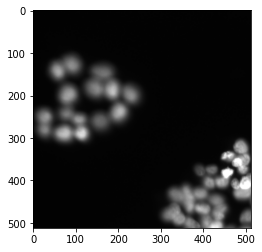

In [22]:
path = "../../Datasets/211202NDA/NDAcquisition-01_XY256.ome.tif"
img = cv2.imread(path)
img = img[100:612,100:612,:]
plt.imshow(img)

In [24]:
model.eval()
output = model(eval_transform(img).unsqueeze(0))[0]

print(output["boxes"].shape)
print(output["labels"].shape)
print(output["scores"].shape)
print(output["masks"].shape)

print(output["labels"])
print(output["scores"])

torch.Size([100, 4])
torch.Size([100])
torch.Size([100])
torch.Size([100, 1, 512, 512])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
tensor([0.9805, 0.9800, 0.9668, 0.9492, 0.9455, 0.9441, 0.9439, 0.9367, 0.9297,
        0.9110, 0.9054, 0.8899, 0.8892, 0.8799, 0.8616, 0.8606, 0.8539, 0.8212,
        0.8211, 0.8151, 0.8141, 0.7879, 0.7758, 0.7700, 0.7684, 0.7654, 0.7425,
        0.7326, 0.7300, 0.7142, 0.7083, 0.6596, 0.6501, 0.5984, 0.5917, 0.5870,
        0.5870, 0.5829, 0.5822, 0.5121, 0.5070, 0.5053, 0.5007, 0.4724, 0.4698,
        0.4686, 0.4560, 0.4519, 0.4502, 0.4433, 0.4412, 0.4312, 0.4002, 0.3761,
        0.3727, 0.3671, 0.3656, 0.3652, 0.3479, 0.3305, 0.3143, 0.3057, 0.2955,
        0.2

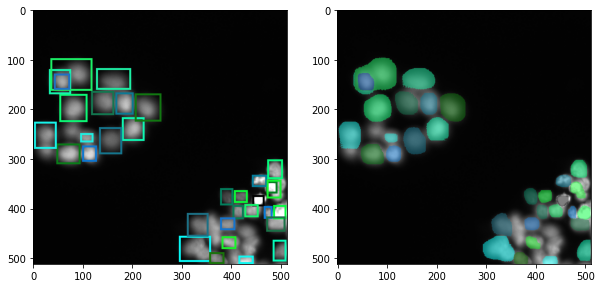

In [26]:
score_threshold = 0.6
backimg = torch.tensor(np.transpose(img,(2,0,1)))

boxes = output['boxes'][output['scores'] > score_threshold]
with_boxes = draw_bounding_boxes(backimg, boxes, width=4)

masks = output['masks'][output['scores'] > score_threshold][:,0,:,:].ge(0.5)
with_masks = draw_segmentation_masks(backimg, masks, alpha=0.5)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.transpose(with_boxes,(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(with_masks,(1,2,0)))

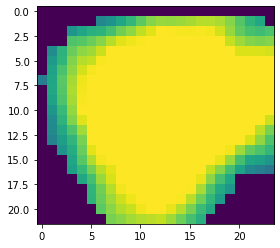

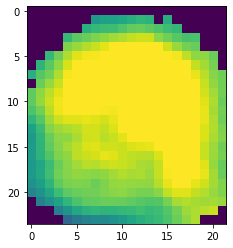

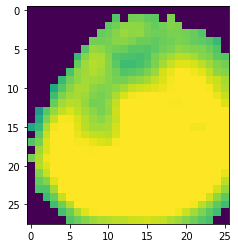

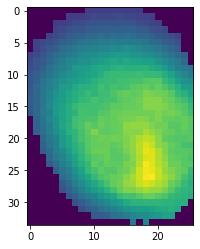

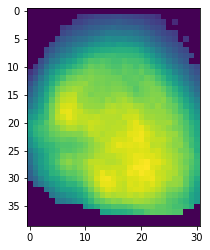

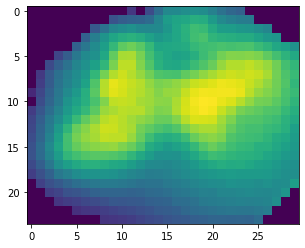

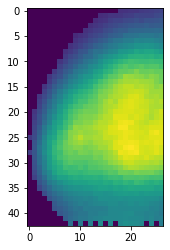

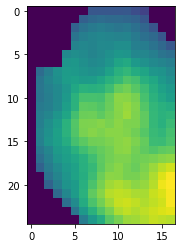

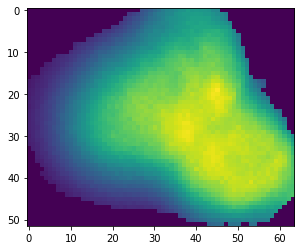

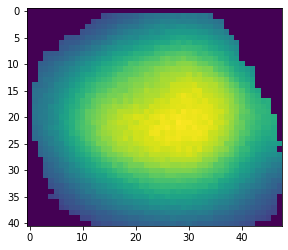

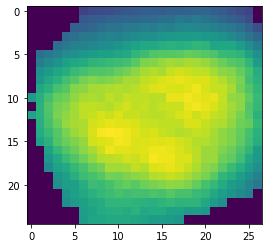

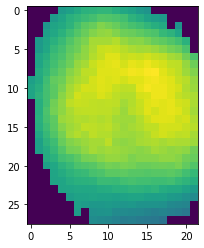

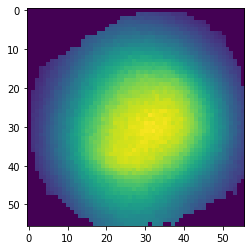

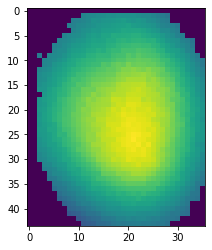

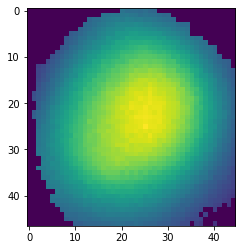

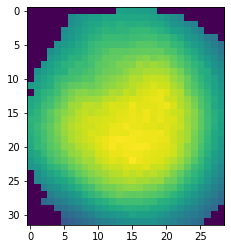

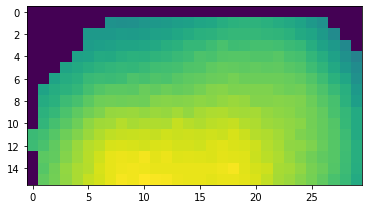

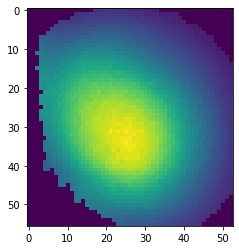

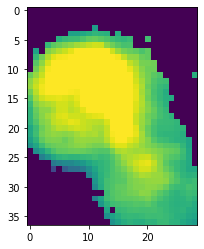

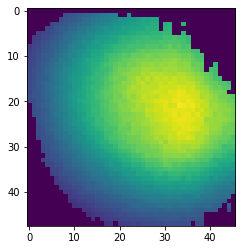

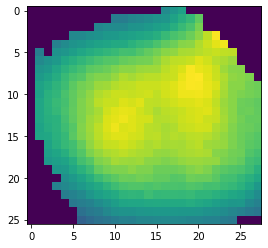

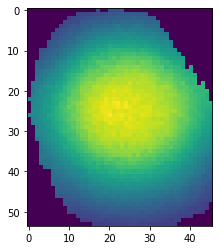

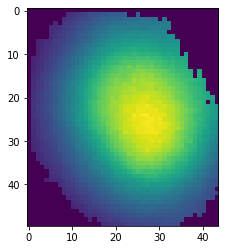

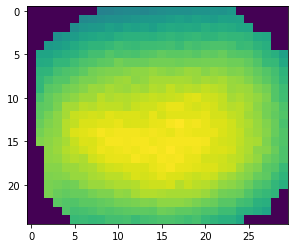

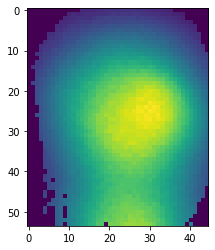

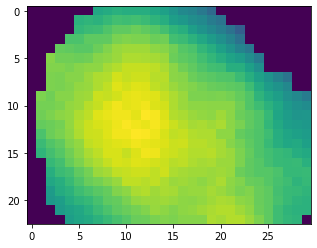

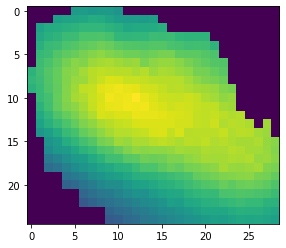

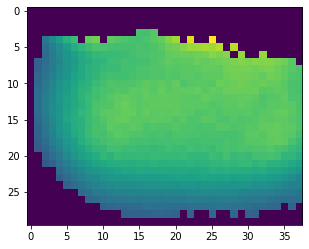

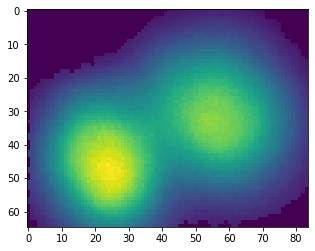

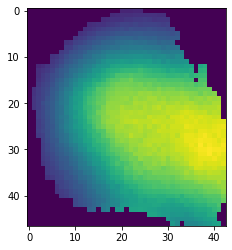

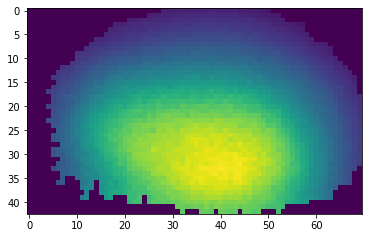

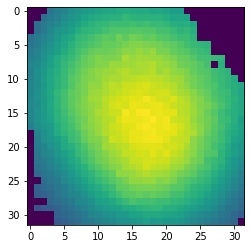

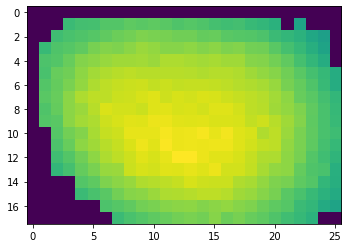

In [27]:
backimg = torch.tensor(img[:,:,0])
for n in range(len(masks)):
#     im = backimg.masked_fill_(masks[n]==False, 0)
#     im = np.transpose(im,(1,2,0))
    im = np.multiply(masks[n],backimg)
    x1,x2,y1,y2 = int(boxes[n,1].item()),int(boxes[n,3].item()),int(boxes[n,0].item()),int(boxes[n,2].item())
    onecell = im[x1:x2,y1:y2]
    plt.imshow(onecell)
    plt.show()

In [236]:
torch.amax(masks[0])

tensor(True)

# Utilities

In [18]:
# ref: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)


def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

def combine_masks(masks, mask_threshold):
    """
    combine masks into one image
    """
    maskimg = np.zeros((HEIGHT, WIDTH))
    # print(len(masks.shape), masks.shape)
    for m, mask in enumerate(masks,1):
        maskimg[mask>mask_threshold] = m
    return maskimg


def get_filtered_masks(pred):
    """
    filter masks using MIN_SCORE for mask and MAX_THRESHOLD for pixels
    """
    use_masks = []   
    for i, mask in enumerate(pred["masks"]):

        # Filter-out low-scoring results. Not tried yet.
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        if scr > min_score_dict[label]:
            mask = mask.cpu().numpy().squeeze()
            # Keep only highly likely pixels
            binary_mask = mask > mask_threshold_dict[label]
            binary_mask = remove_overlapping_pixels(binary_mask, use_masks)
            use_masks.append(binary_mask)

    return use_masks


In [19]:
def compute_iou(labels, y_pred, verbose=0):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    if verbose:
        print("Number of true objects: {}".format(true_objects))
        print("Number of predicted objects: {}".format(pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    intersection = intersection[1:, 1:] # exclude background
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union
    
    return iou  

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred, verbose) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)


def get_score(ds, mdl):
    """
    Get average IOU mAP score for a dataset
    """
    mdl.eval()
    iouscore = 0
    for i in tqdm(range(len(ds))):
        img, targets = ds[i]
        with torch.no_grad():
            result = mdl([img.to(DEVICE)])[0]
            
        masks = combine_masks(targets['masks'], 0.5)
        labels = pd.Series(result['labels'].cpu().numpy()).value_counts()

        mask_threshold = mask_threshold_dict[labels.sort_values().index[-1]]
        pred_masks = combine_masks(get_filtered_masks(result), mask_threshold)
        iouscore += iou_map([masks],[pred_masks])
    return iouscore / len(ds)
